In [1]:
from super_gradients.training import models
import cv2
from futstats.annotations.anns import Detection
import matplotlib.pyplot as plt
from super_gradients.training.processing import DetectionCenterPadding, StandardizeImage, NormalizeImage, ImagePermute, ComposeProcessing, DetectionLongestMaxSizeRescale

[2023-10-09 19:39:17] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-10-09 19:39:18] WARNING - __init__.py - Failed to import pytorch_quantization


The console stream is logged into /home/fer/sg_logs/console.log


/home/fer/miniconda3/envs/futstats/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-10-09 19:39:20] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-10-09 19:39:20] WARNING - export.py - Failed to import pytorch_quantization
[2023-10-09 19:39:20] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [2]:
import torch
print(torch.__version__)
torch.cuda.is_available()

True

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
CLASSES = [
    "0",
    "1",
    "10",
    "11",
    "12",
    "13",
    "14",
    "15",
    "16",
    "17",
    "18",
    "19",
    "2",
    "20",
    "21",
    "22",
    "23",
    "24",
    "25",
    "26",
    "27",
    "28",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
]

NUM_CLASES = len(CLASSES)

In [5]:
cktp_path = "./checkpoints/FIELD_KEYPOINTS_COCO/ckpt_best.pth"

model = models.get("yolo_nas_s",
                num_classes=NUM_CLASES,
                checkpoint_path=cktp_path)


model.set_dataset_processing_params(
    image_processor = ComposeProcessing(
    [
        DetectionLongestMaxSizeRescale(output_shape=(636, 636)),
        DetectionCenterPadding(output_shape=(640, 640), pad_value=114),
        StandardizeImage(max_value=255.0),
        ImagePermute(permutation=(2, 0, 1)),
    ]
)
)

1.13.1+cu117


[2023-10-09 19:39:21] INFO - checkpoint_utils.py - Successfully loaded model weights from ./checkpoints/FIELD_KEYPOINTS_COCO/ckpt_best.pth EMA checkpoint.


In [6]:
img = cv2.cvtColor(cv2.imread('../images/frame.png'), cv2.COLOR_BGR2RGB)
field = cv2.cvtColor(cv2.imread('../images/field_2d.jpg'), cv2.COLOR_BGR2RGB)

In [7]:

results = list(model.predict(img, conf=0.25))[0]
detections = Detection.from_yoloNas(pred=results)

[2023-10-09 19:39:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


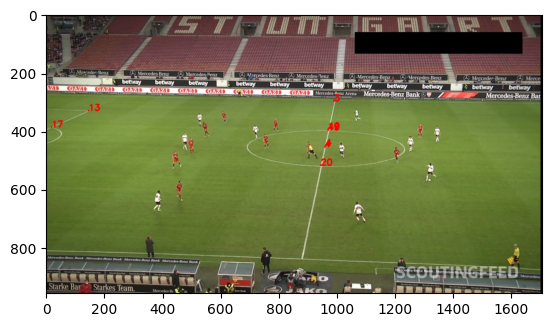

In [10]:

points = img.copy()

for detection in detections:
    x2, y2 = detection.rect.bottom_right.int_xy_tuple
    x1, y1 = detection.rect.top_left.int_xy_tuple
    # get the center of the box
    center = (int((x1 + x2) / 2),int((y1 + y2) / 2))
    points = cv2.circle(points, center, 3, (255, 0, 0), -1)
    points = cv2.putText(points, str(detection.class_id), center, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0),3)



plt.imshow(points)

In [ ]:
(base) fer@linux-mint-fer:~$ pip install nvidia-cudnn-cu11==8.6.0.163
(base) fer@linux-mint-fer:~$ conda install -c conda-forge cudatoolkit=11.8.0
